In [1]:
import json
import os
import shutil

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")

import ast
from collections import Counter

import matplotlib.pyplot as plt
import pydicom as dicom
import seaborn as sns
import sklearn
import tensorflow as tf
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tqdm import tqdm

### Files

 - __train_study_level.csv__ - the train study-level metadata, with one row for each study, including correct labels.
 - __train_image_level.csv__ - the train image-level metadata, with one row for each image, including both correct labels and any bounding boxes in a dictionary format. Some images in both test and train have multiple bounding boxes.
 - __sample_submission.csv__ - a sample submission file containing all image- and study-level IDs.
 
 
### Columns

__train_study_level.csv__


 - ___id___ - unique study identifier
 - ___Negative for Pneumonia___ - 1 if the study is negative for pneumonia, 0 otherwise
 - ___Typical Appearance___ - 1 if the study has this appearance, 0 otherwise
 - ___Indeterminate Appearance___  - 1 if the study has this appearance, 0 otherwise
 - ___Atypical Appearance___  - 1 if the study has this appearance, 0 otherwise  
 
 
__train_image_level.csv__

 - ___id___ - unique image identifier
 - ___boxes___ - bounding boxes in easily-readable dictionary format
 - ___label___ - the correct prediction label for the provided bounding boxes

In [2]:
TRAIN_IMG_PATH = "/app/_data/train/"
TEST_IMG_PATH = "/app/_data/test/"

In [3]:
train_image_level = pd.read_csv("/app/_data/train_image_level.csv")
train_study_level = pd.read_csv("/app/_data/train_study_level.csv")

In [4]:
sample_submission = pd.read_csv("/app/_data/sample_submission.csv")

In [5]:
sample_submission.loc[:10]

id    PredictionString
0   00188a671292_study  negative 1 0 0 1 1
1   004bd59708be_study  negative 1 0 0 1 1
2   00508faccd39_study  negative 1 0 0 1 1
3   006486aa80b2_study  negative 1 0 0 1 1
4   00655178fdfc_study  negative 1 0 0 1 1
5   00a81e8f1051_study  negative 1 0 0 1 1
6   00be7de16711_study  negative 1 0 0 1 1
7   00c7a3928f0f_study  negative 1 0 0 1 1
8   00d63957bc3a_study  negative 1 0 0 1 1
9   0107f2d291d6_study  negative 1 0 0 1 1
10  0154653179fa_study  negative 1 0 0 1 1

# train_image_level

In [6]:
train_image_level.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75  
1                                     none 1 0 0 1 1     ff0879eb20ed  
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7  
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2  
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e

In [7]:
train_image_level.loc[4, 'label']

'opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667'

In [8]:
train_image_level[train_image_level['StudyInstanceUID']=='4b93ca3c31ad']['label'].values

array(['opacity 1 587.42021 1377.02752 1021.5339799999999 1573.0789100000002 opacity 1 503.39817 1092.28628 694.78168 1162.30459 opacity 1 540.74129 802.87709 690.1137900000001 924.2421999999999 opacity 1 620.09541 471.45691 820.81471 616.16147 opacity 1 2048.46975 494.79633 2146.4953800000003 634.8330100000001 opacity 1 2235.18535 1040.93945 2407.89726 1157.63672 opacity 1 2263.19269 1395.69908 2421.90094 1661.76878 opacity 1 2193.17433 452.7853 2323.87526 546.14312'],
      dtype=object)

In [9]:
train_image_level.describe()

id                                              boxes  \
count                 6334                                               4294   
unique                6334                                               4294   
top     5fb9c3bc1e1c_image  [{'x': 430.0432, 'y': 1427.87619, 'width': 847...   
freq                     1                                                  1   

                 label StudyInstanceUID  
count             6334             6334  
unique            4295             6054  
top     none 1 0 0 1 1     0fd2db233deb  
freq              2040                9

 - 6334 unique values in the train_image_level dataframe,
 - 4294 unique boxes,
 - 4295 unique labels (include ___none 1 0 0 1 1___),
 - 6054 unique StudyInstanceUID

In [10]:
train_image_level["image"] = train_image_level["id"].str.replace("_image", ".dcm")

In [11]:
train_image_level.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                     none 1 0 0 1 1     ff0879eb20ed   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   

              image  
0  000a312787f2.dcm  
1  000c3a3f293f.dcm  
2  0012ff7358bc.dcm  
3  001398f4ff4f.dcm  
4  001bd15d1891.dcm

# train_study_level

In [12]:
train_study_level.head()

id  Negative for Pneumonia  Typical Appearance  \
0  00086460a852_study                       0                   1   
1  000c9c05fd14_study                       0                   0   
2  00292f8c37bd_study                       1                   0   
3  005057b3f880_study                       1                   0   
4  0051d9b12e72_study                       0                   0   

   Indeterminate Appearance  Atypical Appearance  
0                         0                    0  
1                         0                    1  
2                         0                    0  
3                         0                    0  
4                         0                    1

 - ___Negative for Pneumonia___ - No lung opacities
 - ___Typical Appearance___ - Multifocal bilateral, peripheral opacities with rounded morphology, lower lung–predominant distribution
 - ___Indeterminate Appearance___ - Absence of typical findings AND unilateral, central or upper lung predominant distribution
 - ___Atypical Appearance___ - Pneumothorax, pleural effusion, pulmonary edema, lobar consolidation, solitary lung nodule or mass, diffuse tiny nodules, cavity

In [13]:
train_study_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        6054 non-null   object
 1   Negative for Pneumonia    6054 non-null   int64 
 2   Typical Appearance        6054 non-null   int64 
 3   Indeterminate Appearance  6054 non-null   int64 
 4   Atypical Appearance       6054 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 236.6+ KB


In [14]:
train_study_level.describe()

Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
count             6054.000000         6054.000000               6054.000000   
mean                 0.276842            0.471589                  0.173274   
std                  0.447475            0.499233                  0.378515   
min                  0.000000            0.000000                  0.000000   
25%                  0.000000            0.000000                  0.000000   
50%                  0.000000            0.000000                  0.000000   
75%                  1.000000            1.000000                  0.000000   
max                  1.000000            1.000000                  1.000000   

       Atypical Appearance  
count          6054.000000  
mean              0.078295  
std               0.268658  
min               0.000000  
25%               0.000000  
50%               0.000000  
75%               0.000000  
max               1.000000

 - most of the images  (47.2%) have typical appearance of pneumonia
 - 27.7% of images negative for pneumonia
 - 17.3% of images have indeterminate appearance of pneumonia
 - 7.8% of images have atypical appearance of pneumonia 
 
We have only 6054 studies in train_study_level dataframe. The number of unique id in study dataframe differs from the unique id in the images dataframe.

Let's check if there are studies with more than one class or without label

In [15]:
sum(
    train_study_level[
        [
            "Negative for Pneumonia",
            "Typical Appearance",
            "Indeterminate Appearance",
            "Atypical Appearance",
        ]
    ].values.sum(axis=1)
    > 1
)

0

In [16]:
sum(
    train_study_level[
        [
            "Negative for Pneumonia",
            "Typical Appearance",
            "Indeterminate Appearance",
            "Atypical Appearance",
        ]
    ].values.sum(axis=1)
    == 0
)

0

All studies have only one label.  
Let's do columns with classes

In [17]:
classes = {"negative": 0, "typical": 1, "indeterminate": 2, "atypical": 3}
for ix in train_study_level.index.tolist():
    if train_study_level.loc[ix, "Negative for Pneumonia"] == 1:
        train_study_level.loc[ix, "class"] = "negative"
    elif train_study_level.loc[ix, "Typical Appearance"] == 1:
        train_study_level.loc[ix, "class"] = "typical"
    elif train_study_level.loc[ix, "Indeterminate Appearance"] == 1:
        train_study_level.loc[ix, "class"] = "indeterminate"
    elif train_study_level.loc[ix, "Atypical Appearance"] == 1:
        train_study_level.loc[ix, "class"] = "atypical"

In [18]:
train_study_level["StudyInstanceUID"] = train_study_level["id"].str[:-6]

### merge dataframes into one on 'StudyInstanceUID'

In [19]:
train = train_image_level.merge(
    train_study_level, on="StudyInstanceUID", how="outer", suffixes=["_image", "_study"]
)

## Studies with several images

In [20]:
train[train["StudyInstanceUID"].duplicated(keep=False)].sort_values("StudyInstanceUID")

id_image                                              boxes  \
2641  6534a837497d_image                                                NaN   
2642  74077a8e3b7c_image  [{'x': 2175.24285, 'y': 1123.72368, 'width': 4...   
2266  f5451a98d684_image                                                NaN   
2265  55e22c0c5de0_image  [{'x': 455.99999, 'y': 1480.00008, 'width': 26...   
4024  9e4824fcee2e_image  [{'x': 817.77961, 'y': 1075.34501, 'width': 64...   
...                  ...                                                ...   
1727  4123a71d9796_image  [{'x': 889.45144, 'y': 282.39441, 'width': 825...   
903   218bcf950372_image                                                NaN   
904   e6cc65d9de1d_image                                                NaN   
779   1c96d9b08487_image                                                NaN   
780   84ed5f7f71bf_image  [{'x': 1721.27651, 'y': 974.09667, 'width': 12...   

                                                  label StudyInstanceUID  \
2641                                     none 1 0 0 1 1     00f9e183938e   
2642  opacity 1 2175.24285 1123.72368 2607.50603 162...     00f9e183938e   
2266                                     none 1 0 0 1 1     0142feaef82f   
2265  opacity 1 455.99999 1480.00008 722.39998 2437....     0142feaef82f   
4024  opacity 1 817.77961 1075.34501 1467.08961 2075...     0369e0385796   
...                                                 ...              ...   
1727  opacity 1 889.45144 282.39441 1714.51125 1585....     fc45007f145a   
903                                      none 1 0 0 1 1     fd92c6f2b2e6   
904                                      none 1 0 0 1 1     fd92c6f2b2e6   
779                                      none 1 0 0 1 1     ffcb4630f46f   
780   opacity 1 1721.27651 974.09667 2999.21998 2681...     ffcb4630f46f   

                 image            id_study  Negative for Pneumonia  \
2641  6534a837497d.dcm  00f9e183938e_study                       0   
2642  74077a8e3b7c.dcm  00f9e183938e_study                       0   
2266  f5451a98d684.dcm  0142feaef82f_study                       0   
2265  55e22c0c5de0.dcm  0142feaef82f_study                       0   
4024  9e4824fcee2e.dcm  0369e0385796_study                       0   
...                ...                 ...                     ...   
1727  4123a71d9796.dcm  fc45007f145a_study                       0   
903   218bcf950372.dcm  fd92c6f2b2e6_study                       1   
904   e6cc65d9de1d.dcm  fd92c6f2b2e6_study                       1   
779   1c96d9b08487.dcm  ffcb4630f46f_study                       0   
780   84ed5f7f71bf.dcm  ffcb4630f46f_study                       0   

      Typical Appearance  Indeterminate Appearance  Atypical Appearance  \
2641                   0                         0                    1   
2642                   0                         0                    1   
2266                   0                         1                    0   
2265                   0                         1                    0   
4024                   1                         0                    0   
...                  ...                       ...                  ...   
1727                   1                         0                    0   
903                    0                         0                    0   
904                    0                         0                    0   
779                    1                         0                    0   
780                    1                         0                    0   

              class  
2641       atypical  
2642       atypical  
2266  indeterminate  
2265  indeterminate  
4024        typical  
...             ...  
1727        typical  
903        negative  
904        negative  
779         typical  
780         typical  

[512 rows x 11 columns]

In [21]:
train[train["StudyInstanceUID"].duplicated(keep=False)].sort_values("StudyInstanceUID")[
    "StudyInstanceUID"
].unique().shape

(232,)

In [22]:
train["StudyInstanceUID"].value_counts().head(20)

0fd2db233deb    9
a7335b2f9815    7
8943d1d85097    6
a0254bf8a96e    5
a4e94133d95a    5
970c96c9fa5d    5
7e91e041c7d4    4
74ba8f2badcb    4
79c3bf957d49    4
c39d68397d84    4
9168dcefe508    3
4bdad39035b0    3
21b8491fb0e0    3
d8fa04c1d853    3
9c95946da400    3
8f08039e8b7f    3
26648048b098    3
0d9709b3af74    3
7416b5cbc531    3
81f6b4b343f7    3
Name: StudyInstanceUID, dtype: int64

As we can see, 232 studies have from 9 to 2 images. 
For several of that studies there are no bounding boxes, but they are labeled as if they have some type of pneumonia, not negative.

## Dicom images

## extracting paths to images and metadata

In [23]:
# for ix in tqdm(train.index.tolist()):
#     first_folder = train.loc[ix, "StudyInstanceUID"]
#     inner_folder = os.listdir(TRAIN_IMG_PATH + first_folder)
#     img_name = train.loc[ix, "id_image"][:-6] + ".dcm"
#     for j in inner_folder:
#         if img_name in os.listdir(TRAIN_IMG_PATH + first_folder + "/" + j):
#             img_path = os.path.join(TRAIN_IMG_PATH, first_folder, j, img_name)
#             train.loc[ix, "path"] = img_path
#             data_file = dicom.dcmread(img_path)
#             train.loc[ix, "modality"] = data_file.Modality
#             train.loc[ix, "PatientSex"] = data_file.PatientSex
#             train.loc[ix, "BodyPartExamined"] = data_file.BodyPartExamined
#             train.loc[
#                 ix, "PhotometricInterpretation"
#             ] = data_file.PhotometricInterpretation
#             train.loc[ix, "Rows"] = data_file.Rows
#             train.loc[ix, "Columns"] = data_file.Columns
#             train.loc[ix, "width"] = data_file.pixel_array.shape[1]
#             train.loc[ix, "height"] = data_file.pixel_array.shape[0]
train = pd.read_csv('/app/_data/train.csv')

In [24]:
train.sample()

id_image boxes           label StudyInstanceUID  \
3896  981b09433923_image   NaN  none 1 0 0 1 1     dbb6d75304ef   

                 image            id_study  Negative for Pneumonia  \
3896  981b09433923.dcm  dbb6d75304ef_study                       1   

      Typical Appearance  Indeterminate Appearance  Atypical Appearance  ...  \
3896                   0                         0                    0  ...   

     BodyPartExamined PhotometricInterpretation    Rows Columns   width  \
3896          unknown               MONOCHROME2  2801.0  2798.0  2798.0   

      height  n_bbox  modality_id  p_sex  body_part_id  
3896  2801.0       0            0      1            11  

[1 rows x 24 columns]

Let's look at some images:

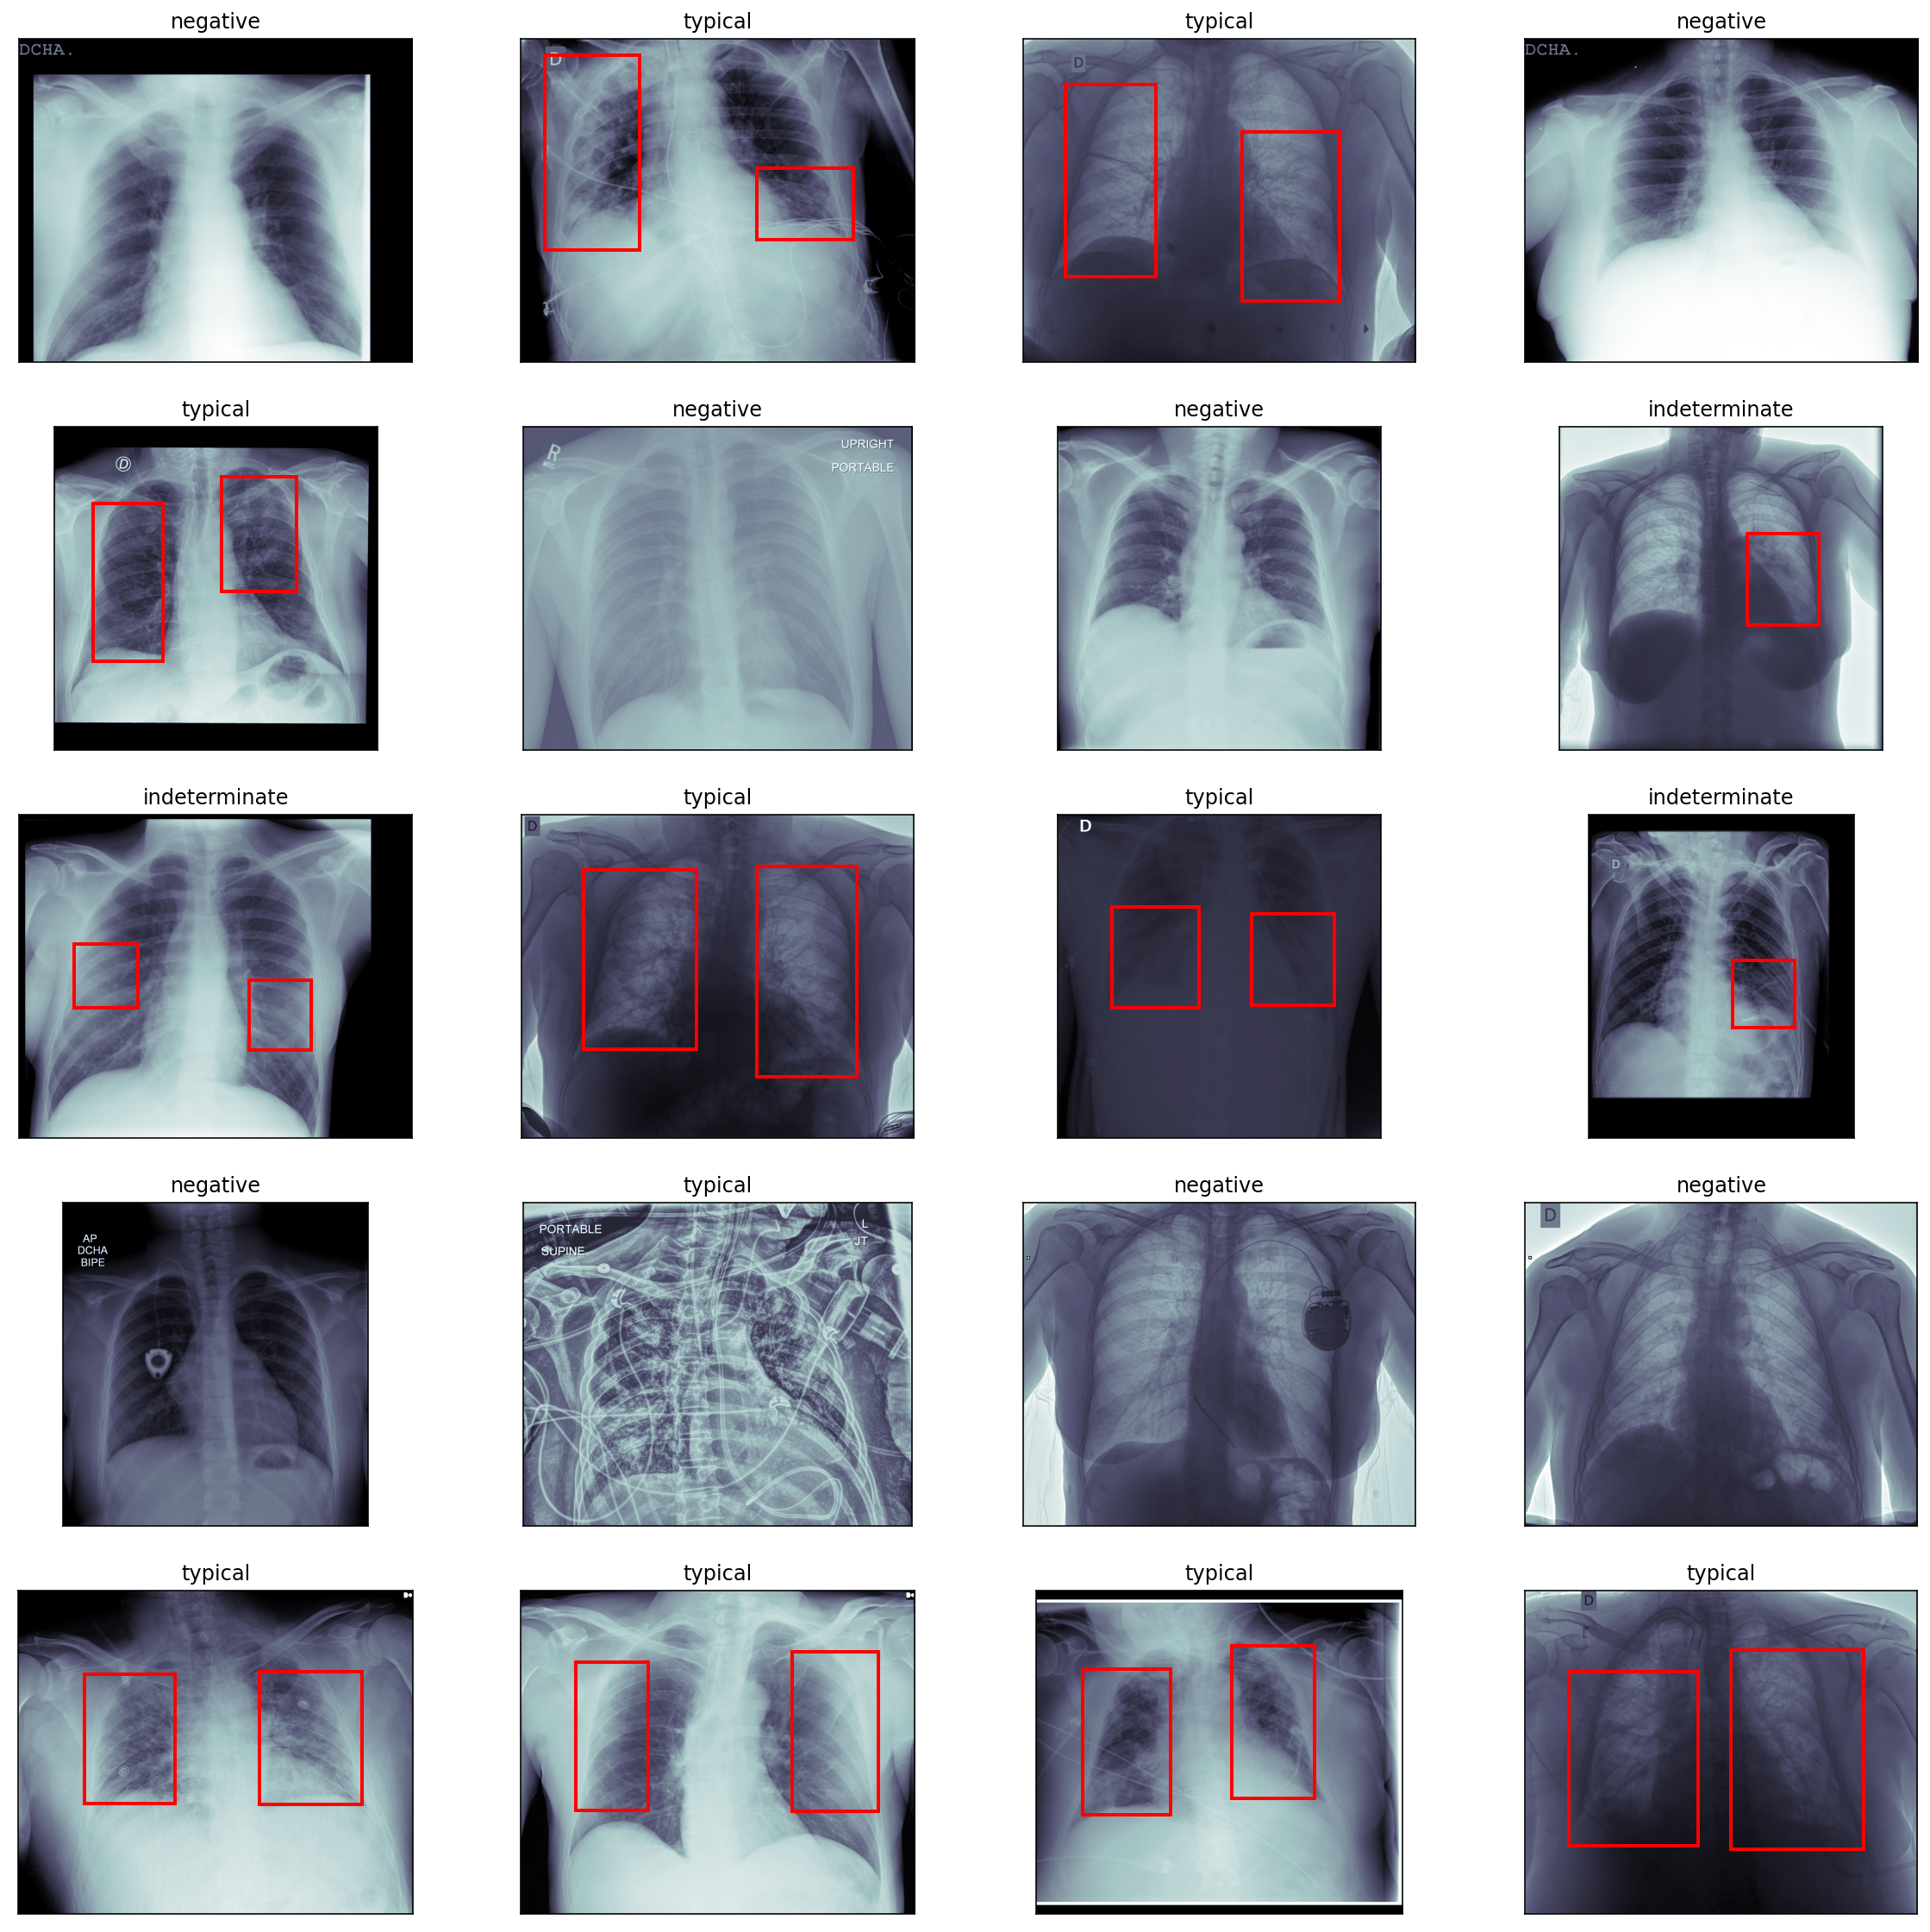

In [25]:
plt.figure(figsize=(20, 20))
sample_df = train.sample(20).reset_index(drop=True)
for i in range(20):
    img = dicom.dcmread(sample_df.loc[i]["path"])
    img = img.pixel_array
    label = sample_df.loc[i, "class"]
    ax = plt.subplot(5, 4, i + 1)
    if type(sample_df.loc[i, "boxes"]) != float:
        boxes = ast.literal_eval(sample_df.loc[i, "boxes"])
        for box in boxes:
            rect = plt.Rectangle(
                (box["x"], box["y"]),
                box["width"],
                box["height"],
                ec="r",
                fc="none",
                lw=2.0,
            )
            ax.add_patch(rect)
    plt.title(label)
    ax.imshow(img, cmap=plt.cm.bone)
    plt.xticks([])
    plt.yticks([])
plt.show();

## count opacities

In [26]:
train["n_bbox"] = train["label"].str.count("opacity")

In [27]:
train["n_bbox"].value_counts()

2    3113
0    2040
1     973
3     183
4      23
8       1
5       1
Name: n_bbox, dtype: int64

In [28]:
train[train["n_bbox"] == 8]

id_image                                              boxes  \
4560  b570de3efeed_image  [{'x': 587.42021, 'y': 1377.02752, 'width': 43...   

                                                  label StudyInstanceUID  \
4560  opacity 1 587.42021 1377.02752 1021.5339799999...     4b93ca3c31ad   

                 image            id_study  Negative for Pneumonia  \
4560  b570de3efeed.dcm  4b93ca3c31ad_study                       0   

      Typical Appearance  Indeterminate Appearance  Atypical Appearance  ...  \
4560                   1                         0                    0  ...   

     BodyPartExamined PhotometricInterpretation    Rows Columns   width  \
4560            CHEST               MONOCHROME2  2544.0  3056.0  3056.0   

      height  n_bbox  modality_id  p_sex  body_part_id  
4560  2544.0       8            1      1             2  

[1 rows x 24 columns]

In [29]:
train[(train["n_bbox"] == 0) & (train["Negative for Pneumonia"] != 1)]

id_image boxes           label StudyInstanceUID  \
22    00c1515729a8_image   NaN  none 1 0 0 1 1     1a58b43cf286   
31    0102b5cac730_image   NaN  none 1 0 0 1 1     81f6b4b343f7   
32    b3ffe59e37c7_image   NaN  none 1 0 0 1 1     81f6b4b343f7   
76    025bf835bba6_image   NaN  none 1 0 0 1 1     f4ead5d70ba6   
129   04a0b90d7875_image   NaN  none 1 0 0 1 1     effcdb73627e   
...                  ...   ...             ...              ...   
6194  fa38e3491eec_image   NaN  none 1 0 0 1 1     8087e3bc0efe   
6213  fb38bfebfabd_image   NaN  none 1 0 0 1 1     37f638aff743   
6282  fe1ce39cfa13_image   NaN  none 1 0 0 1 1     71e052c9da68   
6312  fef5d9dd40e4_image   NaN  none 1 0 0 1 1     4b4d19205cf6   
6320  ff4cd60f14b7_image   NaN  none 1 0 0 1 1     be16979f2071   

                 image            id_study  Negative for Pneumonia  \
22    00c1515729a8.dcm  1a58b43cf286_study                       0   
31    0102b5cac730.dcm  81f6b4b343f7_study                       0   
32    b3ffe59e37c7.dcm  81f6b4b343f7_study                       0   
76    025bf835bba6.dcm  f4ead5d70ba6_study                       0   
129   04a0b90d7875.dcm  effcdb73627e_study                       0   
...                ...                 ...                     ...   
6194  fa38e3491eec.dcm  8087e3bc0efe_study                       0   
6213  fb38bfebfabd.dcm  37f638aff743_study                       0   
6282  fe1ce39cfa13.dcm  71e052c9da68_study                       0   
6312  fef5d9dd40e4.dcm  4b4d19205cf6_study                       0   
6320  ff4cd60f14b7.dcm  be16979f2071_study                       0   

      Typical Appearance  Indeterminate Appearance  Atypical Appearance  ...  \
22                     1                         0                    0  ...   
31                     1                         0                    0  ...   
32                     1                         0                    0  ...   
76                     0                         0                    1  ...   
129                    1                         0                    0  ...   
...                  ...                       ...                  ...  ...   
6194                   0                         0                    1  ...   
6213                   0                         0                    1  ...   
6282                   0                         0                    1  ...   
6312                   0                         0                    1  ...   
6320                   0                         0                    1  ...   

     BodyPartExamined PhotometricInterpretation    Rows Columns   width  \
22              TORAX               MONOCHROME2  2539.0  3050.0  3050.0   
31         PORT CHEST               MONOCHROME2  2544.0  3056.0  3056.0   
32         PORT CHEST               MONOCHROME2  2544.0  3056.0  3056.0   
76              CHEST               MONOCHROME2  2330.0  2846.0  2846.0   
129             CHEST               MONOCHROME2  2520.0  3032.0  3032.0   
...               ...                       ...     ...     ...     ...   
6194            CHEST               MONOCHROME1  2800.0  3408.0  3408.0   
6213          unknown               MONOCHROME2  2268.0  2242.0  2242.0   
6282            CHEST               MONOCHROME2  2330.0  2846.0  2846.0   
6312            CHEST               MONOCHROME1  2166.0  2989.0  2989.0   
6320            CHEST               MONOCHROME2  3480.0  4240.0  4240.0   

      height  n_bbox  modality_id  p_sex  body_part_id  
22    2539.0       0            1      1             9  
31    2544.0       0            1      0             4  
32    2544.0       0            1      0             4  
76    2330.0       0            1      1             2  
129   2520.0       0            1      0             2  
...      ...     ...          ...    ...           ...  
6194  2800.0       0            1      1             2  
6213  2268.0       0            0      1            

In the dataset we have 304 rows, with no opacities, but they are not negative for pneumonia

In [30]:
train[(train["n_bbox"] == 0) & (train["Negative for Pneumonia"] != 1)][
    "StudyInstanceUID"
].value_counts()

0fd2db233deb    8
a7335b2f9815    6
8943d1d85097    5
970c96c9fa5d    4
a4e94133d95a    4
               ..
c3da9334b162    1
03c62bc287b6    1
c15db163ce39    1
2708e654cd46    1
31557085aaef    1
Name: StudyInstanceUID, Length: 261, dtype: int64

Some of theese studies have several images, but not all of them.

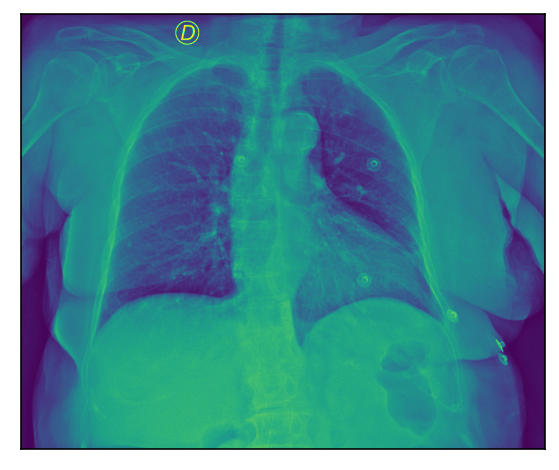

In [29]:
img = dicom.dcmread(train.loc[129, "path"])
img = img.pixel_array
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show();

In [30]:
list_studies = train[(train["n_bbox"] == 0) & (train["Negative for Pneumonia"] != 1)][
    "StudyInstanceUID"
]

In [31]:
train_short = train.query("StudyInstanceUID not in @list_studies").reset_index(
    drop=True
)

## inverted images

Among all images there are inverted images

In [32]:
train["PhotometricInterpretation"].unique()

array(['MONOCHROME2', 'MONOCHROME1'], dtype=object)

___MONOCHROME1___
Pixel data represent a single monochrome image plane. The minimum sample value is intended to be displayed as white.

___MONOCHROME2___
Pixel data represent a single monochrome image plane. The minimum sample value is intended to be displayed as black.

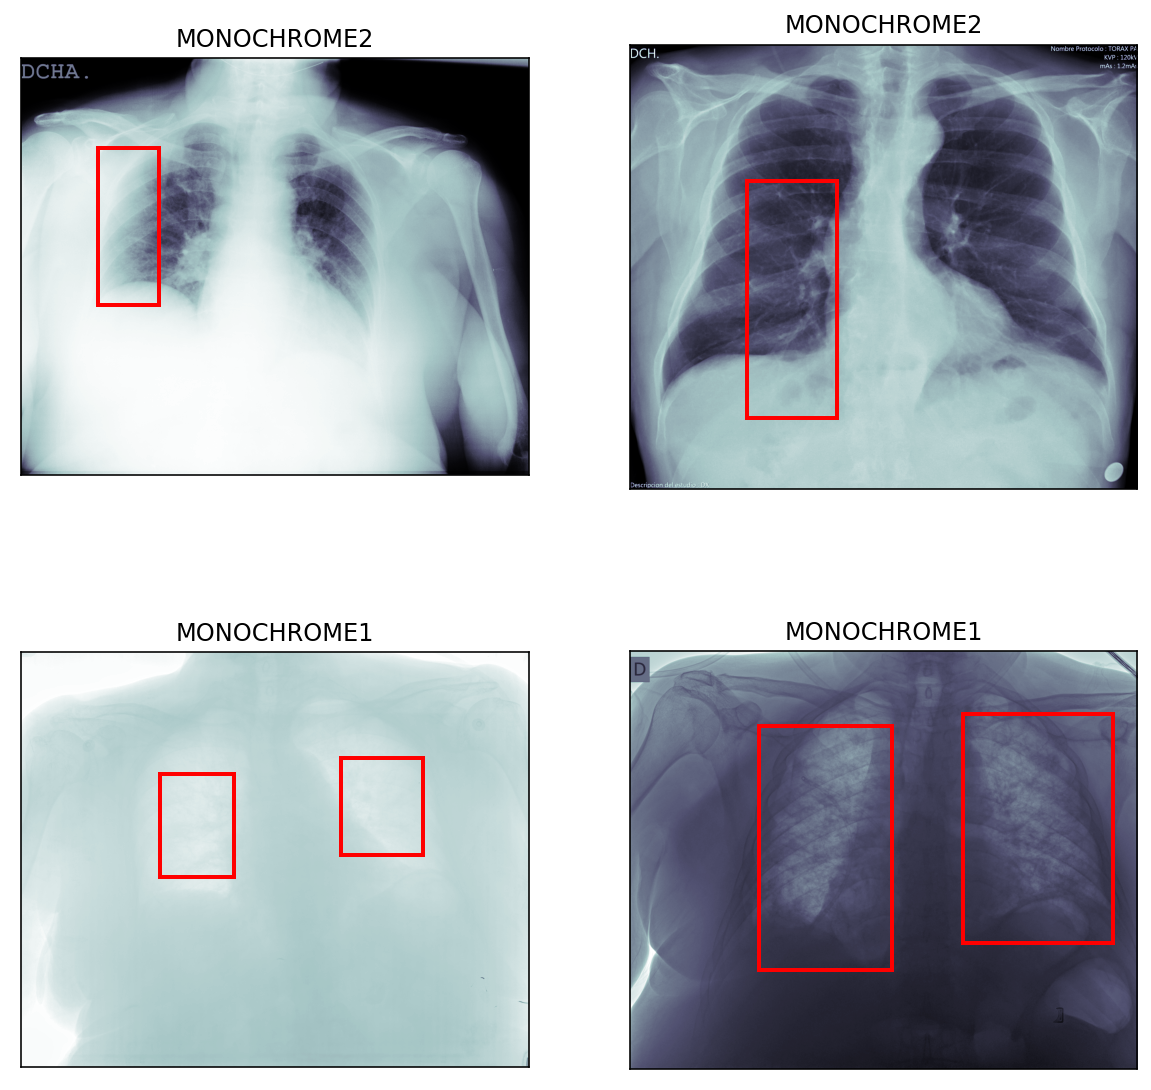

In [33]:
plt.figure(figsize=(10, 10))
sample_df1 = (
    train[train["PhotometricInterpretation"] == "MONOCHROME2"]
    .sample(2)
    .reset_index(drop=True)
)
sample_df2 = (
    train[train["PhotometricInterpretation"] == "MONOCHROME1"]
    .sample(2)
    .reset_index(drop=True)
)
sample_df = pd.concat([sample_df1, sample_df2], axis=0, ignore_index=True)
for i in range(4):
    img = dicom.dcmread(sample_df.loc[i]["path"])
    img = img.pixel_array
    if type(sample_df.loc[i, "boxes"]) != float:
        boxes = ast.literal_eval(sample_df.loc[i, "boxes"])
    ax = plt.subplot(2, 2, i + 1)
    for box in boxes:
        rect = plt.Rectangle(
            (box["x"], box["y"]), box["width"], box["height"], ec="r", fc="none", lw=2.0
        )
        ax.add_patch(rect)
    plt.title(sample_df.loc[i, "PhotometricInterpretation"])
    ax.imshow(img, cmap=plt.cm.bone)
    plt.xticks([])
    plt.yticks([])
plt.show();

As we can see, images with PhotometricInterpretation==MONOCHROME1 are reverted images. To deal with this we must substract image from the maximum value.

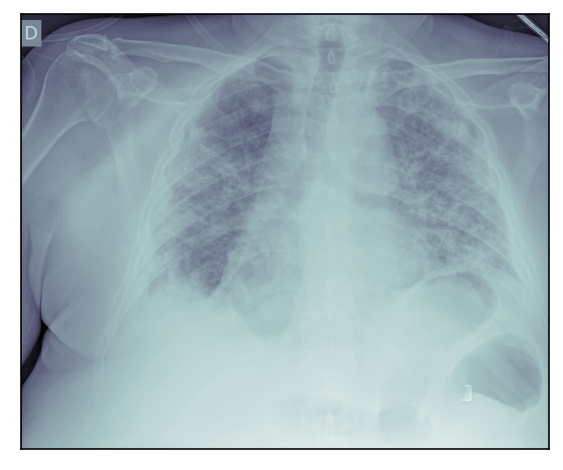

In [34]:
i = img.max() - img
plt.imshow(i, cmap=plt.cm.bone)
plt.xticks([])
plt.yticks([])
plt.show();

## metadata

In [35]:
dict_body_part = {}
for i in range(len(sorted(train["BodyPartExamined"].unique().tolist()))):
    dict_body_part[sorted(train["BodyPartExamined"].unique().tolist())[i]] = i

In [36]:
dict_metadata = {
    "modality": {"CR": 0, "DX": 1, "unknown": 2},
    "PatientSex": {"F": 0, "M": 1, "unknown": 2},
    "BodyPartExamined": {
        "2- TORAX": 0,
        "ABDOMEN": 1,
        "CHEST": 2,
        "PECHO": 3,
        "PORT CHEST": 4,
        "Pecho": 5,
        "SKULL": 6,
        "T?RAX": 7,
        "THORAX": 8,
        "TORAX": 9,
        "TÒRAX": 10,
        "unknown": 11,
    },
    "class": {"negative": 0, "typical": 1, "indeterminate": 2, "atypical": 3},
}

In [37]:
file_json = open("/app/_data/dict_metadata.json", "w")
json.dump(dict_metadata, file_json)
file_json.close()

In [38]:
train["modality"].value_counts()
train["modality"].isna().sum()

DX    3242
CR    3092
Name: modality, dtype: int64

0

DX - Digital Radiography  
CR - Computed Radiography  
Computed radiography (CR) cassettes use photo-stimulated luminescence screens to capture the X-ray image, instead of traditional X-ray film. The CR cassette goes into a reader to convert the data into a digital image. Digital radiography (DR) systems use active matrix flat panels consisting of a detection layer deposited over an active matrix array of thin film transistors and photodiodes.

In [39]:
train["modality_id"] = train["modality"].replace(dict_metadata["modality"])

In [40]:
train["PhotometricInterpretation"].value_counts()
train["PhotometricInterpretation"].isna().sum()

MONOCHROME2    4633
MONOCHROME1    1701
Name: PhotometricInterpretation, dtype: int64

0

In [41]:
train["PatientSex"].value_counts()
train["PatientSex"].isna().sum()

M    3564
F    2770
Name: PatientSex, dtype: int64

0

In [42]:
train["p_sex"] = train["PatientSex"].replace(dict_metadata["PatientSex"])

In [43]:
train["BodyPartExamined"].value_counts()
train["BodyPartExamined"].isna().sum()

CHEST         5050
unknown        381
TORAX          307
PORT CHEST     249
T?RAX          156
THORAX          77
SKULL           57
Pecho           21
ABDOMEN         21
2- TORAX         7
TÒRAX            5
PECHO            3
Name: BodyPartExamined, dtype: int64

0

In [44]:
train["BodyPartExamined"] = train["BodyPartExamined"].replace("", "unknown")

In [45]:
train["body_part_id"] = train["BodyPartExamined"].replace(
    dict_metadata["BodyPartExamined"]
)

In [46]:
train[["BodyPartExamined", "body_part_id"]]

BodyPartExamined  body_part_id
0               CHEST             2
1               CHEST             2
2          PORT CHEST             4
3               CHEST             2
4               CHEST             2
...               ...           ...
6329            CHEST             2
6330            CHEST             2
6331            TORAX             9
6332            CHEST             2
6333            CHEST             2

[6334 rows x 2 columns]

In [47]:
# train.to_csv("/app/_data/train.csv", index=False)

In [48]:
train

id_image                                              boxes  \
0     000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1     000c3a3f293f_image                                                NaN   
2     0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3     001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4     001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
...                  ...                                                ...   
6329  ffcc6edd9445_image                                                NaN   
6330  ffd91a2c4ca0_image                                                NaN   
6331  ffd9b6cf2961_image  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6332  ffdc682f7680_image  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6333  ffe942c8655f_image  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label StudyInstanceUID  \
0     opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                        none 1 0 0 1 1     ff0879eb20ed   
2     opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4     opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   
...                                                 ...              ...   
6329                                     none 1 0 0 1 1     7e6c68462e06   
6330                                     none 1 0 0 1 1     8332bdaddb6e   
6331  opacity 1 2197.38566 841.07361 2513.80265 1292...     7eed9af03814   
6332  opacity 1 2729.27083 332.26044 4225.52099 2936...     a0cb0b96fb3d   
6333  opacity 1 208.86463 91.53448 659.8321 719.5892...     7d82d53204b8   

                 image            id_study  Negative for Pneumonia  \
0     000a312787f2.dcm  5776db0cec75_study                       0   
1     000c3a3f293f.dcm  ff0879eb20ed_study                       1   
2     0012ff7358bc.dcm  9d514ce429a7_study                       0   
3     001398f4ff4f.dcm  28dddc8559b2_study                       0   
4     001bd15d1891.dcm  dfd9fdd85a3e_study                       0   
...                ...                 ...                     ...   
6329  ffcc6edd9445.dcm  7e6c68462e06_study                       1   
6330  ffd91a2c4ca0.dcm  8332bdaddb6e_study                       1   
6331  ffd9b6cf2961.dcm  7eed9af03814_study                       0   
6332  ffdc682f7680.dcm  a0cb0b96fb3d_study                       0   
6333  ffe942c8655f.dcm  7d82d53204b8_study                       0   

      Typical Appearance  Indeterminate Appearance  Atypical Appearance  ...  \
0                      1                         0                    0  ...   
1                      0                         0                    0  ...   
2                      1                         0                    0  ...   
3                      0                         0                    1  ...   
4                      1                         0                    0  ...   
...                  ...                       ...                  ...  ...   
6329                   0                         0                    0  ...   
6330                   0                         0                    0  ...   
6331                   1                         0                    0  ...   
6332                   1                         0                    0  ...   
6333                   1                         0                    0  ...   

     BodyPartExamined PhotometricInterpretation    Rows Columns   width  \
0               CHEST               MONOCHROME2  3488.0  4256.0  4256.0   
1               CHEST               MONOCHROME2  2320.0  2832.0  2832.0   
2          PORT CHEST               MONOCHROME2  2544.0  3056.0  3056.0   
3               CHEST               MONOCHROME1  352

In [48]:
train_short = train.query("StudyInstanceUID not in @list_studies").reset_index(
    drop=True
)

In [49]:
train_short.to_csv("/app/_data/train_short.csv", index=False)

In [70]:
voi_lut = True
fix_monochrome = True


def dicom_dataset_to_dict(filename, func):
    """Credit: https://github.com/pydicom/pydicom/issues/319
    https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    """

    dicom_header = dicom.dcmread(filename)

    # ====== DICOM FILE DATA ======
    dicom_dict = {}
    repr(dicom_header)
    for dicom_value in dicom_header.values():
        if dicom_value.tag == (0x7FE0, 0x0010):
            # discard pixel data
            continue
        if type(dicom_value.value) == dicom.dataset.Dataset:
            dicom_dict[dicom_value.name] = dicom_dataset_to_dict(dicom_value.value)
        else:
            v = _convert_value(dicom_value.value)
            dicom_dict[dicom_value.name] = v

    del dicom_dict["Pixel Representation"]

    if func != "metadata_df":
        # ====== DICOM IMAGE DATA ======
        # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(dicom_header.pixel_array, dicom_header)
        else:
            data = dicom_header.pixel_array
        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and dicom_header.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        modified_image_data = (data * 255).astype(np.uint8)

        return dicom_dict, modified_image_data

    else:
        return dicom_dict


def _sanitise_unicode(s):
    return s.replace(u"\u0000", "").strip()


def _convert_value(v):
    t = type(v)
    if t in (list, int, float):
        cv = v
    elif t == str:
        cv = _sanitise_unicode(v)
    elif t == bytes:
        s = v.decode("ascii", "replace")
        cv = _sanitise_unicode(s)
    elif t == dicom.valuerep.DSfloat:
        cv = float(v)
    elif t == dicom.valuerep.IS:
        cv = int(v)
    else:
        cv = repr(v)
    return cv

In [71]:
metadata = []
for filename in tqdm(train.path[0:6334]):
    metadata.append(dicom_dataset_to_dict(filename, "metadata_df"))

100%|██████████| 6334/6334 [00:45<00:00, 140.22it/s]


In [ ]:
pd.DataFrame(metadata)["Study Date"].value_counts()

In [ ]:
train.query()

In [ ]:
sum(
    train[
        [
            "Negative for Pneumonia",
            "Typical Appearance",
            "Indeterminate Appearance",
            "Atypical Appearance",
        ]
    ].values.sum(axis=1)
    > 1
)

## convert to jpg

In [54]:
for ix in tqdm(train.index.tolist()):
    img_path = train.loc[ix,'path']
    img_name = train.loc[ix,'id_image'][:-6]
    img_type = train.loc[ix, 'PhotometricInterpretation']
    data = dicom.dcmread(img_path)
    img = dicom.pixel_data_handlers.util.apply_voi_lut(data.pixel_array, data)
    if img_type == "MONOCHROME1":
        img = img.max() - img
    img = (img - img.min()) / (img.max() - img.min())
    img = (np.array(img) * 255).astype("uint8")
    img = np.stack([img, img, img], axis=-1)
    img = Image.fromarray(img)
    img.save("/app/_data/jpg/"+img_name+'.jpg')

100%|██████████| 6334/6334 [36:29<00:00,  2.89it/s]  


# convert to png

In [32]:
for ix in tqdm(train.index.tolist()):
    img_path = train.loc[ix,'path']
    img_name = train.loc[ix,'id_image'][:-6]
    img_type = train.loc[ix, 'PhotometricInterpretation']
    data = dicom.dcmread(img_path)
    img = dicom.pixel_data_handlers.util.apply_voi_lut(data.pixel_array, data)
    if img_type == "MONOCHROME1":
        img = img.max() - img
    img = (img - img.min()) / (img.max() - img.min())
    img = (np.array(img) * 255).astype("uint8")
    img = np.stack([img, img, img], axis=-1)
    img = Image.fromarray(img)
    img.save("/app/_data/png/"+img_name+'.png', format='png')

100%|██████████| 6334/6334 [3:54:04<00:00,  2.22s/it]  


In [58]:
ix=5
img_path = train.loc[ix,'path']
img_name = train.loc[ix,'id_image'][:-6]
img_type = train.loc[ix, 'PhotometricInterpretation']
data = dicom.dcmread(img_path)
img = dicom.pixel_data_handlers.util.apply_voi_lut(data.pixel_array, data)
if img_type == "MONOCHROME1":
    img = img.max() - img
img = (img - img.min()) / (img.max() - img.min())
img = (np.array(img) * 255).astype("uint8")
img = Image.fromarray(img)

In [60]:
np.array(img).max()
np.array(img).min()


255

0

In [51]:
# shutil.rmtree('/app/_data/yolov5/runs/train/yolov5x_trans_0')

In [ ]:
img.shape

# images and bounding boxes

In [11]:
train = pd.read_csv("/app/_data/train.csv")

In [18]:
a = train.sample(2)
a

id_image                                              boxes  \
2301  578c73ebd02a_image  [{'x': 723.4694, 'y': 174.4, 'width': 901.0666...   

                                                  label StudyInstanceUID  \
2301  opacity 1 723.4694 174.4 1624.53607 2336.96 op...     54d3bd418490   

                 image            id_study  Negative for Pneumonia  \
2301  578c73ebd02a.dcm  54d3bd418490_study                       0   

      Typical Appearance  Indeterminate Appearance  Atypical Appearance  ...  \
2301                   1                         0                    0  ...   

                                                   path modality PatientSex  \
2301  /app/_data/train/54d3bd418490/30e50ba000eb/578...       DX          M   

     BodyPartExamined PhotometricInterpretation    Rows  Columns   width  \
2301            CHEST               MONOCHROME2  3488.0   4256.0  4256.0   

      height  n_bbox  
2301  3488.0       2  

[1 rows x 21 columns]

In [27]:
a["boxes"].values

array(["[{'x': 723.4694, 'y': 174.4, 'width': 901.06667, 'height': 2162.56}, {'x': 3322.0294, 'y': 720.85333, 'width': 864.2106, 'height': 2243.94667}]"],
      dtype=object)

In [30]:
boxes = ast.literal_eval(a.loc[2301, "boxes"])

In [35]:
w = a.loc[2301, "width"]
h = a.loc[2301, "height"]

In [48]:
l = []
for box in boxes:
    l.append(
        [
            box["x"] / w,
            box["y"] / h,
            (box["x"] + box["width"]) / w,
            (box["y"] + box["height"]) / h,
            (box["x"] + box["width"] / 2) / w,
            (box["y"] + box["height"] / 2) / h,
        ]
    )

In [49]:
img = Image.open("/app/_data/jpg/578c73ebd02a.jpg")

In [54]:
l

[[0.16998811090225563,
  0.05,
  0.38170490366541354,
  0.67,
  0.2758465072838346,
  0.36000000000000004],
 [0.7805520206766917,
  0.2066666657110092,
  0.9836090225563909,
  0.8499999999999999,
  0.8820805216165414,
  0.5283333328555047]]

In [53]:
! cat /app/_data/yolo5_dataset/tr_test_42/labels/train/578c73ebd02a.txt

0 0.2758465072838346 0.36000000000000004 0.2117167927631579 0.62
0 0.8820805216165414 0.5283333328555047 0.20305700187969924 0.6433333342889908


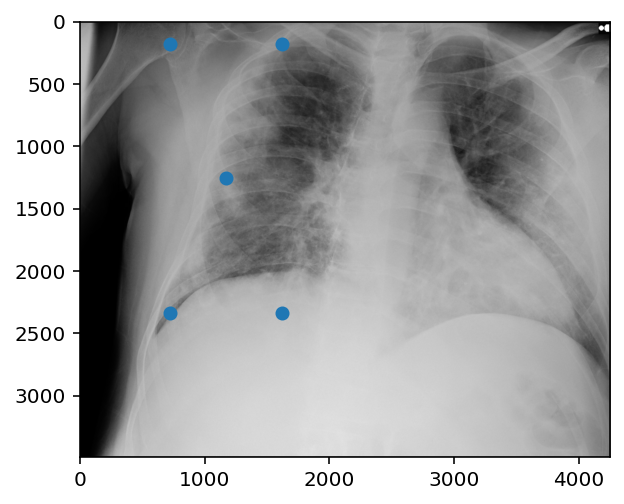

In [51]:
plt.imshow(img)
plt.scatter(
    [l[0][0] * w, l[0][0] * w, l[0][2] * w, l[0][2] * w, l[0][4] * w],
    [l[0][1] * h, l[0][3] * h, l[0][3] * h, l[0][1] * h, l[0][5] * h],
)

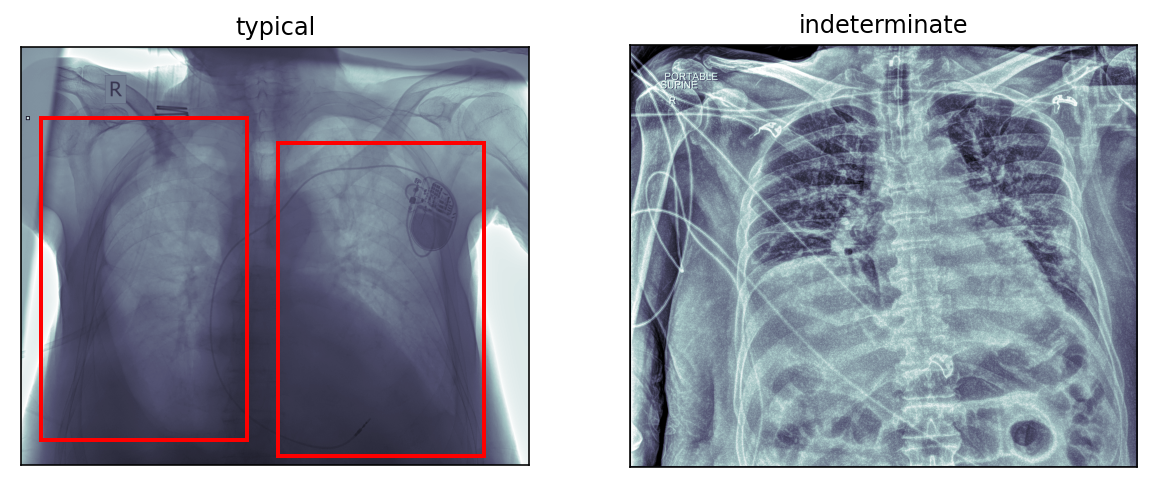

In [21]:
plt.figure(figsize=(10, 5))
sample_df = train.sample(2).reset_index(drop=True)
for i in range(2):
    img = dicom.dcmread(sample_df.loc[i]["path"])
    img = img.pixel_array
    label = sample_df.loc[i, "class"]
    ax = plt.subplot(1, 2, i + 1)
    if type(sample_df.loc[i, "boxes"]) != float:
        boxes = ast.literal_eval(sample_df.loc[i, "boxes"])
        for box in boxes:
            rect = plt.Rectangle(
                (box["x"], box["y"]),
                box["width"],
                box["height"],
                ec="r",
                fc="none",
                lw=2.0,
            )
            ax.add_patch(rect)
    plt.title(label)
    ax.imshow(img, cmap=plt.cm.bone)
    plt.xticks([])
    plt.yticks([])
plt.show();

In [22]:
sample_df

id_image                                              boxes  \
0  7f5bf4d22256_image  [{'x': 107.52089, 'y': 397.12, 'width': 1152.4...   
1  dcb374d8387e_image                                                NaN   

                                               label StudyInstanceUID  \
0  opacity 1 107.52089 397.12 1259.94756 2199.733...     1cbbe74b7fcf   
1                                     none 1 0 0 1 1     b27172e0b2f1   

              image            id_study  Negative for Pneumonia  \
0  7f5bf4d22256.dcm  1cbbe74b7fcf_study                       0   
1  dcb374d8387e.dcm  b27172e0b2f1_study                       0   

   Typical Appearance  Indeterminate Appearance  Atypical Appearance  ...  \
0                   1                         0                    0  ...   
1                   0                         1                    0  ...   

                                                path modality PatientSex  \
0  /app/_data/train/1cbbe74b7fcf/245224ce5268/7f5...       DX          M   
1  /app/_data/train/b27172e0b2f1/15645903692f/dcb...       DX          M   

  BodyPartExamined PhotometricInterpretation    Rows  Columns   width  height  \
0            CHEST               MONOCHROME1  2336.0   2836.0  2836.0  2336.0   
1            CHEST               MONOCHROME2  2520.0   3032.0  3032.0  2520.0   

   n_bbox  
0       2  
1       0  

[2 rows x 21 columns]

## test

In [36]:
test_df = pd.DataFrame()
for folder1 in tqdm(os.listdir(TEST_IMG_PATH)):
    for folder2 in os.listdir(TEST_IMG_PATH + folder1):
        path = os.path.join(TEST_IMG_PATH, folder1, folder2)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            test_df.loc[img, "path"] = img_path
            data_file = dicom.dcmread(img_path)
            test_df.loc[img, "StudyInstanceUID"] = folder1
            test_df.loc[img, "id_image"] = img[:-4]
            test_df.loc[img, "modality"] = data_file.Modality
            test_df.loc[img, "PatientSex"] = data_file.PatientSex
            test_df.loc[img, "BodyPartExamined"] = data_file.BodyPartExamined
            test_df.loc[
                img, "PhotometricInterpretation"
            ] = data_file.PhotometricInterpretation
            test_df.loc[img, "Rows"] = data_file.Rows
            test_df.loc[img, "Columns"] = data_file.Columns
            test_df.loc[img, "width"] = data_file.pixel_array.shape[1]
            test_df.loc[img, "height"] = data_file.pixel_array.shape[0]

100%|██████████| 1214/1214 [01:10<00:00, 17.19it/s]


In [37]:
test_df = test_df.reset_index(drop=True)

In [38]:
test_df

path StudyInstanceUID  \
0     /app/_data/test/fe64182ae21d/d56579abcb25/a82c...     fe64182ae21d   
1     /app/_data/test/6117058c3931/d51d2a5e7f7a/b74f...     6117058c3931   
2     /app/_data/test/b83eaac8a377/326c25201eea/1c13...     b83eaac8a377   
3     /app/_data/test/9fab41ffbc39/5b8d372f6714/fa0c...     9fab41ffbc39   
4     /app/_data/test/4e4ee0341fab/70ae5f9ad500/dc68...     4e4ee0341fab   
...                                                 ...              ...   
1258  /app/_data/test/2b9ad8c6a010/f251e7f2407f/ebf5...     2b9ad8c6a010   
1259  /app/_data/test/f85b5d51e41d/2d7b14036f33/f785...     f85b5d51e41d   
1260  /app/_data/test/f66894c11824/096698ca90ea/88de...     f66894c11824   
1261  /app/_data/test/92d320a0719d/e76f6b98e5f5/b854...     92d320a0719d   
1262  /app/_data/test/514c5133572d/db1f16a85e54/eb9a...     514c5133572d   

          id_image modality PatientSex BodyPartExamined  \
0     a82ca8f37fb6       CR          F            CHEST   
1     b74f81d65e79       DX          M            CHEST   
2     1c13336fc8a9       DX          M            CHEST   
3     fa0c84ee4577       CR          F            CHEST   
4     dc6834a1efa6       CR          F            CHEST   
...            ...      ...        ...              ...   
1258  ebf5edbbed2d       DX          M            CHEST   
1259  f785f9c6bbf7       DX          M            CHEST   
1260  88debce8e1c3       DX          F            CHEST   
1261  b854ff324fbb       DX          M            CHEST   
1262  eb9a9b9a0870       DX          M            CHEST   

     PhotometricInterpretation    Rows  Columns   width  height  
0                  MONOCHROME2  3480.0   4248.0  4248.0  3480.0  
1                  MONOCHROME2  3032.0   3032.0  3032.0  3032.0  
2                  MONOCHROME2  2520.0   3032.0  3032.0  2520.0  
3                  MONOCHROME1  3480.0   4240.0  4240.0  3480.0  
4                  MONOCHROME2  2597.0   2621.0  2621.0  2597.0  
...                        ...     ...      ...     ...     ...  
1258               MONOCHROME1  2800.0   3408.0  3408.0  2800.0  
1259               MONOCHROME2  2800.0   3285.0  3285.0  2800.0  
1260               MONOCHROME2  2544.0   3056.0  3056.0  2544.0  
1261               MONOCHROME2  2203.0   2170.0  2170.0  2203.0  
1262               MONOCHROME2  2330.0   2673.0  2673.0  2330.0  

[1263 rows x 11 columns]

In [39]:
test_df["PatientSex"].unique()

array(['F', 'M'], dtype=object)

In [40]:
test_df["BodyPartExamined"].unique()

array(['CHEST', 'TORAX', 'THORAX', 'PORT CHEST', '', 'T?RAX', 'TÒRAX',
       'ABDOMEN', 'SKULL', 'Pecho', '2- TORAX', 'PECHO'], dtype=object)

In [41]:
test_df["PhotometricInterpretation"].unique()

array(['MONOCHROME2', 'MONOCHROME1'], dtype=object)

In [42]:
test_df["modality"].unique()

array(['CR', 'DX'], dtype=object)

In [43]:
set(train["BodyPartExamined"].unique()) == set(test_df["BodyPartExamined"].unique())

True

## COCO_dataset

In [44]:
d = {
    "info": {
        "description": "COCO COVID-19 Detection",
        "url": "https://www.kaggle.com/c/siim-covid19-detection",
        "version": "1.0",
        "year": 2021,
        "date_created": "06-06-2021",
    },
    "licenses": ["no"],
    "images": [],
    "annotations": [...],
    "categories": [...],
}

In [ ]:
# images
{
    "id": int,
    "width": int,
    "height": int,
    "file_name": str,
    "license": int,
    "flickr_url": str,
    "coco_url": str,
    "date_captured": datetime,
}

In [ ]:
# categories
{
    "id": int,
    "name": str,
    "supercategory": str,
}

In [ ]:
annotation{
"id": int,
"image_id": int,
"category_id": int,
"segmentation": [], 
"area": float,
"bbox": [x,y,width,height],
"iscrowd": 0,
}

In [ ]:
json_dict = {"images": [], "type": "instances", "annotations": [], "categories": []}

In [ ]:
images = []
for i in train.index.tolist()

In [ ]:
"images": [
    {
        "file_name": "000000397133.jpg",
        "coco_url": "http://images.cocodataset.org/val2017/000000397133.jpg",
        "height": 427,
        "width": 640,
        "date_captured": "2013-11-14 17:02:52",
        "flickr_url": "http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg",
        "id": 397133
    }